In [1]:
import io
import random
import string
import warnings
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import warnings
warnings.filterwarnings('ignore')


In [2]:
import nltk
from nltk.tokenize import sent_tokenize
from nltk.corpus import words
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.sentiment.util import *

In [3]:
# sklearn imports
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics


In [4]:
# python imports
import re
import json
from collections import Counter

In [5]:
# Visualization
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn import feature_extraction, linear_model, model_selection, preprocessing
from wordcloud import WordCloud
from tqdm import tqdm_notebook


In [6]:
# Saving models
import pickle

In [7]:
tweets_df = pd.read_csv('G:/III Year Workbooks/3-2/bda covid project/datset/2020-03-28 Coronavirus Tweets.CSV')
print(len(tweets_df))
tweets_df.head()

582055


,status_id,user_id,created_at,screen_name,text,source,reply_to_status_id,reply_to_user_id,reply_to_screen_name,is_quote,...,retweet_count,country_code,place_full_name,place_type,followers_count,friends_count,account_lang,account_created_at,verified,lang
0,1243689257929072640,44728980,2020-03-28T00:00:00Z,ANCALERTS,"Nearly 100,000 coronavirus cases in US: tracke...",TweetDeck,NaN,NaN,NaN,False,...,3,NaN,NaN,NaN,4867852,777,NaN,2009-06-04T21:26:24Z,True,en
1,1243689258545709056,15872418,2020-03-28T00:00:00Z,ABSCBNNews,'Like wartime': Filipino doctors overwhelmed b...,TweetDeck,NaN,NaN,NaN,False,...,10,NaN,NaN,NaN,6763409,1075,NaN,2008-08-16T10:09:33Z,True,en
2,1243689258457665541,92174767,2020-03-28T00:00:00Z,DZMMTeleRadyo,Catarman isinailalim sa enhanced community qua...,TweetDeck,NaN,NaN,NaN,False,...,3,NaN,NaN,NaN,1351275,164,NaN,2009-11-24T02:03:16Z,True,tl
3,1243689257224376322,2400082873,2020-03-28T00:00:00Z,gorebiobio,#Toquedequeda A partir de las 22:00 horas y ha...,Twitter Media Studio,NaN,NaN,NaN,False,...,6,NaN,NaN,NaN,26955,851,NaN,2014-03-20T15:52:27Z,True,es
4,1243689257492832256,858044279138263041,2020-03-28T00:00:00Z,ahoramasoficial,"La mortalidad por el #COVID19 es baja, es impo...",Twitter Media Studio,NaN,NaN,NaN,False,...,0,NaN,NaN,NaN,4712,402,NaN,2017-04-28T19:44:32Z,False,es


In [8]:
#trimming un necessary
text_lang_df = tweets_df[['text', 'lang']]
text_lang_df.head()

,text,lang
0,"Nearly 100,000 coronavirus cases in US: tracke...",en
1,'Like wartime': Filipino doctors overwhelmed b...,en
2,Catarman isinailalim sa enhanced community qua...,tl
3,#Toquedequeda A partir de las 22:00 horas y ha...,es
4,"La mortalidad por el #COVID19 es baja, es impo...",es


In [9]:
#ignoring other than english
text_en = text_lang_df[text_lang_df['lang'] == 'en'].reset_index()['text']
print(len(text_en))
text_en.head()

310848


0    Nearly 100,000 coronavirus cases in US: tracke...
1    'Like wartime': Filipino doctors overwhelmed b...
2    Correspondence: Epidemiology of Covid-19. #COV...
3    Advocates have long argued that a safe supply ...
4    Amid the #COVID19 pandemic, the @BCTruckingAss...
Name: text, dtype: object

In [10]:
#remove url
text_en_lr = text_en.apply(lambda x: re.sub(r"https\S+", "", x))
text_en_lr.head()

0    Nearly 100,000 coronavirus cases in US: tracke...
1    'Like wartime': Filipino doctors overwhelmed b...
2    Correspondence: Epidemiology of Covid-19. #COV...
3    Advocates have long argued that a safe supply ...
4    Amid the #COVID19 pandemic, the @BCTruckingAss...
Name: text, dtype: object

In [11]:
#converting to lower case
text_en_lr_lc = text_en_lr.apply(lambda x: x.lower())
text_en_lr_lc.head()

0    nearly 100,000 coronavirus cases in us: tracke...
1    'like wartime': filipino doctors overwhelmed b...
2    correspondence: epidemiology of covid-19. #cov...
3    advocates have long argued that a safe supply ...
4    amid the #covid19 pandemic, the @bctruckingass...
Name: text, dtype: object

In [12]:
#remove punctuations
text_en_lr_lc_pr = text_en_lr_lc.apply(lambda x: x.translate(str.maketrans('', '', string.punctuation)))
text_en_lr_lc_pr.head()

0    nearly 100000 coronavirus cases in us tracker ...
1    like wartime filipino doctors overwhelmed by c...
2    correspondence epidemiology of covid19 covid19...
3    advocates have long argued that a safe supply ...
4    amid the covid19 pandemic the bctruckingassoc ...
Name: text, dtype: object

In [13]:
import nltk
nltk.download('stopwords')
  

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\priya\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [14]:
#remove stopwords
stop_words = set(stopwords.words('english'))
stop_words.update(['#coronavirus', '#coronavirusoutbreak', '#coronavirusPandemic', '#covid19', '#covid_19', '#epitwitter', '#ihavecorona', 'amp'])


In [15]:

text_en_lr_lc_pr_sr = text_en_lr_lc_pr.apply(lambda x: ' '.join([word for word in x.split() if word not in stop_words]))
text_en_lr_lc_pr_sr.head()

0    nearly 100000 coronavirus cases us tracker cov...
1    like wartime filipino doctors overwhelmed covi...
2    correspondence epidemiology covid19 covid19 sa...
3    advocates long argued safe supply would reduce...
4    amid covid19 pandemic bctruckingassoc says can...
Name: text, dtype: object

In [16]:
#concatenatinf tweets into list of words
word_list = [word for line in text_en_lr_lc_pr_sr for word in line.split()]
word_list[:6]

['nearly', '100000', 'coronavirus', 'cases', 'us', 'tracker']

In [17]:
#term frequency
sns.set(style="darkgrid")
counts = Counter(word_list).most_common(50)
counts_df = pd.DataFrame(counts)
counts_df.head()


,0,1
0,covid19,221904
1,coronavirus,144742
2,people,30383
3,coronavirusoutbreak,25113
4,cases,24812


In [18]:
counts_df.columns = ['word', 'frequency']

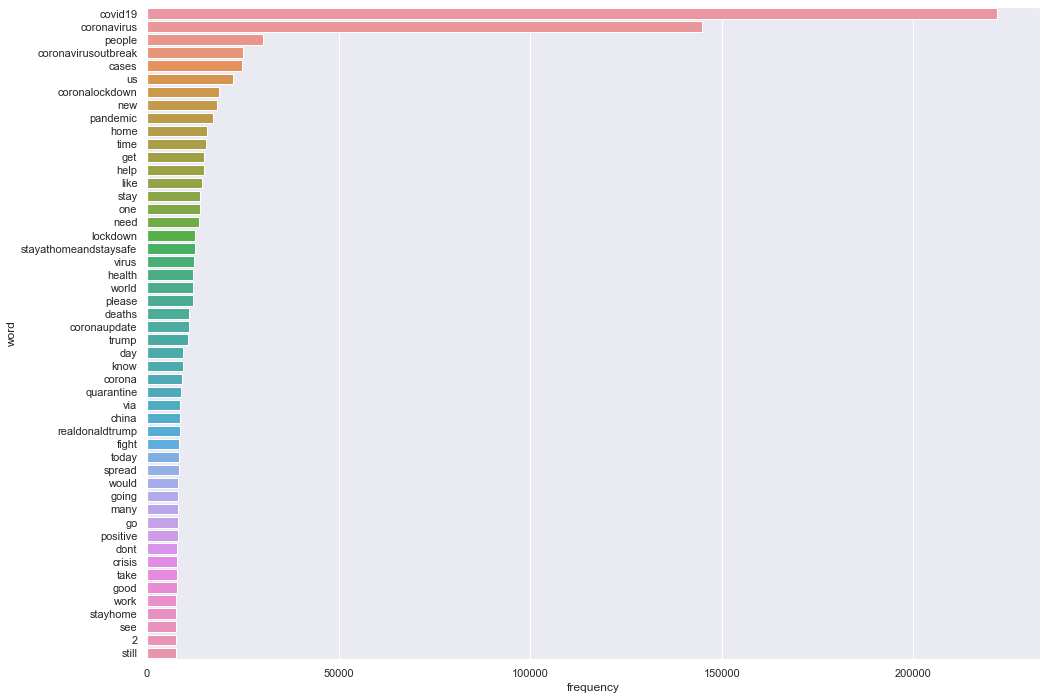

In [19]:
fig, ax = plt.subplots(figsize = (16, 12))
ax = sns.barplot(y="word", x='frequency', ax = ax, data=counts_df)
plt.savefig('wordcount_bar.png')

In [20]:
wordcloud = WordCloud(
    background_color='black',
    max_words=50,
    max_font_size=40, 
    scale=5,
    random_state=1,
    collocations=False,
    normalize_plurals=False
).generate(' '.join(word_list))


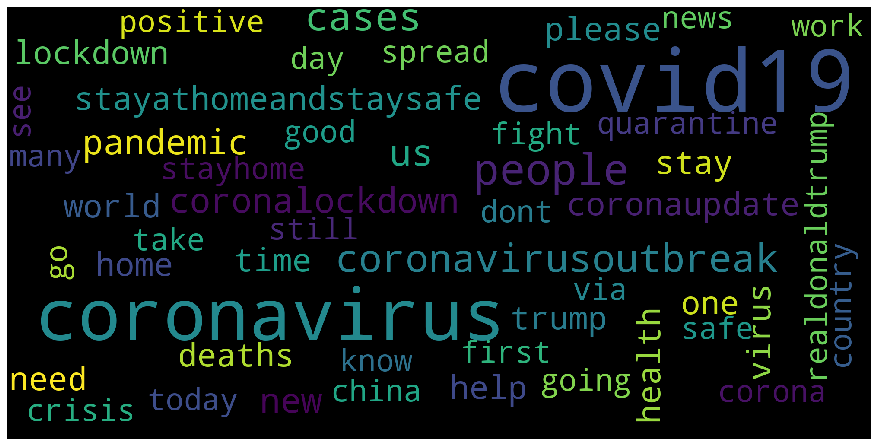

In [21]:
plt.figure(figsize = (12, 10), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)

plt.savefig('wordcloud.png')


In [25]:
import nltk
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\priya\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [26]:
#sentimental analysis
sid = SentimentIntensityAnalyzer()
sentiment_scores = text_en_lr_lc_pr_sr.apply(lambda x: sid.polarity_scores(x))
sent_scores_df = pd.DataFrame(list(sentiment_scores))
sent_scores_df.head()

,compound,neg,neu,pos
0,0.0000,0.000,1.000,0.000
1,0.4019,0.000,0.575,0.425
2,0.0000,0.000,1.000,0.000
3,-0.4404,0.272,0.535,0.193
4,0.4019,0.000,0.769,0.231


In [27]:
#classifying into neu/pos/neg
sent_scores_df['val'] = sent_scores_df['compound'].apply(lambda x: 'neutral' if x == 0 else ('positive' if x > 0 else 'negative'))
sent_scores_df.head()

,compound,neg,neu,pos,val
0,0.0000,0.000,1.000,0.000,neutral
1,0.4019,0.000,0.575,0.425,positive
2,0.0000,0.000,1.000,0.000,neutral
3,-0.4404,0.272,0.535,0.193,negative
4,0.4019,0.000,0.769,0.231,positive


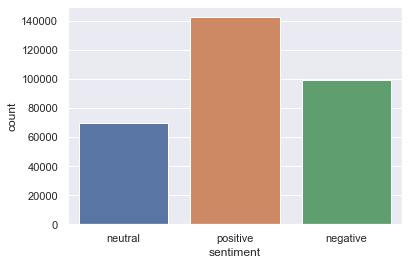

In [28]:
#plotting
sent_counts = pd.DataFrame.from_dict(Counter(sent_scores_df['val']), orient = 'index').reset_index()
sent_counts.columns = ['sentiment', 'count']

sns.barplot(y="count", x='sentiment', data=sent_counts)
plt.savefig('sentiment.png')

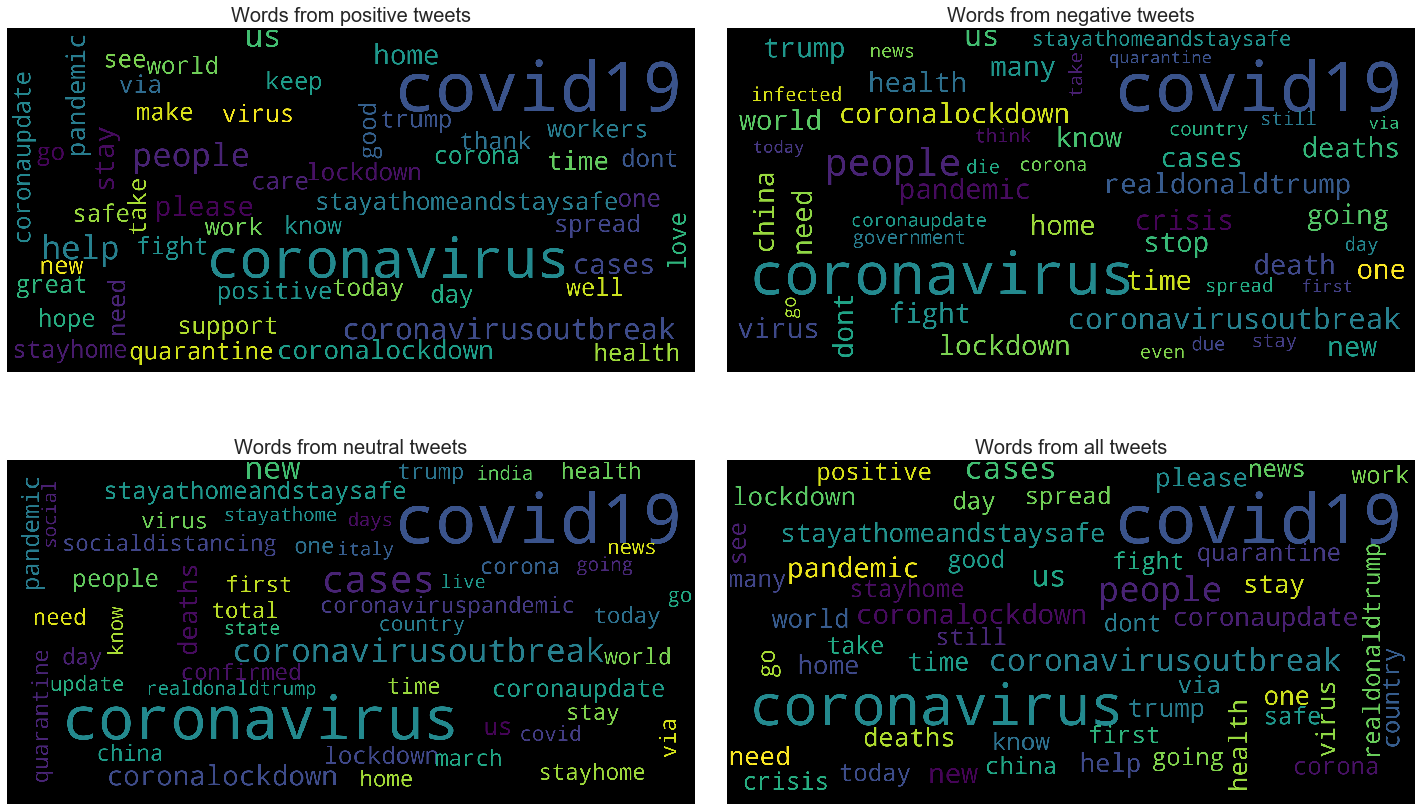

In [29]:
polar_tweets_df = pd.DataFrame()
polar_tweets_df['tweet'] = text_en_lr_lc_pr_sr
polar_tweets_df['polarity'] = sent_scores_df['val']

positive = polar_tweets_df[polar_tweets_df['polarity'] == 'positive']['tweet']
negative = polar_tweets_df[polar_tweets_df['polarity'] == 'negative']['tweet']
neutral = polar_tweets_df[polar_tweets_df['polarity'] == 'neutral']['tweet']

positive_list = [word for line in positive for word in line.split()]
negative_list = [word for line in negative for word in line.split()]
neutral_list = [word for line in neutral for word in line.split()]

positive_cloud = WordCloud(
    background_color='black',
    max_words=50,
    max_font_size=40, 
    scale=5,
    random_state=1,
    collocations=False,
    normalize_plurals=False
).generate(' '.join(positive_list))

negative_cloud = WordCloud(
    background_color='black',
    max_words=50,
    max_font_size=40, 
    scale=5,
    random_state=1,
    collocations=False,
    normalize_plurals=False
).generate(' '.join(negative_list))

neutral_cloud = WordCloud(
    background_color='black',
    max_words=50,
    max_font_size=40, 
    scale=5,
    random_state=1,
    collocations=False,
    normalize_plurals=False
).generate(' '.join(neutral_list))


fig, axs = plt.subplots(2, 2, figsize = (20, 12))
# fig.suptitle('Clouds of polar words', fontsize = 30)
fig.tight_layout(pad = 0)

axs[0, 0].imshow(positive_cloud)
axs[0, 0].set_title('Words from positive tweets', fontsize = 20)
axs[0, 0].axis('off')
# axs[0, 0].tight_layout(pad = 1)

axs[0, 1].imshow(negative_cloud)
axs[0, 1].set_title('Words from negative tweets', fontsize = 20)
axs[0, 1].axis('off')
# axs[0, 1].tight_layout(pad = 1)

axs[1, 0].imshow(neutral_cloud)
axs[1, 0].set_title('Words from neutral tweets', fontsize = 20)
axs[1, 0].axis('off')
# axs[1, 0].tight_layout(pad = 1)

axs[1, 1].imshow(wordcloud)
axs[1, 1].set_title('Words from all tweets', fontsize = 20)
axs[1, 1].axis('off')
# axs[1, 0].tight_layout(pad = 1)
plt.savefig('joint_cloud.png')